In [12]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import os
import seaborn as sns
import scipy.stats as st
import warnings
from scipy.stats import linregress
sns.set()

In [2]:
warnings.filterwarnings('ignore')

# Read in titles data files and create combined DataFrame

In [ ]:
# Data files
netflix_path = "../data/netflix_titles.csv"
disney_path = "../data/disney_plus_titles.csv"

# Read the Netflix and Disney+ data
netflix_data = pd.read_csv(netflix_path)
disney_data = pd.read_csv(disney_path)


In [ ]:
# Create Netflix dataframe and review length
netflix_df = pd.DataFrame(netflix_data)
len(netflix_df)

In [ ]:
# Netflix date_added is the key column for filtering to 2019 - 2021 to align with Disney+ dataset date_added dates
# The following steps trim the "September 24, 2018" dates to remove extra spaces
netflix_df['date_added'] = netflix_df['date_added'].str.strip()
# netflix_df['date_added'] = pd.to_datetime(netflix_df['date_added'], errors='coerce')

# There are a handful of blank date_added that will impact date filtering
netflix_blank_dates = netflix_df[netflix_df['date_added'].isna()]
len(netflix_blank_dates)

In [ ]:
# Drop rows with blank dates
netflix_df = netflix_df.dropna(subset=['date_added'])

# Verify the number of rows with blank dates after dropping
len(netflix_df[netflix_df['date_added'].isna()])

In [ ]:
# Extract only the date portion and convert it to string
netflix_df['date_added'] = pd.to_datetime(netflix_df['date_added'], errors='coerce')
netflix_df['date_added'] = netflix_df['date_added'].dt.date.astype(str)


In [ ]:
# Filter out for dates greater than January 1, 2019
netflix_df = netflix_df.loc[(netflix_df['date_added'] >= '2019-01-01') & (netflix_df['date_added'] <= '2021-12-31')]
len(netflix_df)

In [ ]:
# Create Disney+ dataframe and review length
disney_df = pd.DataFrame(disney_data)
len(disney_df)

In [ ]:
# There are a handful of blank date_added that will impact data
disney_blank_dates = disney_df[disney_df['date_added'].isna()]
len(disney_blank_dates)

In [ ]:
# Drop rows with blank dates
disney_df = disney_df.dropna(subset=['date_added'])

# Verify the number of rows with blank dates after dropping
len(disney_df[disney_df['date_added'].isna()])

In [ ]:
# Extract only the date portion and convert it to string
disney_df['date_added'] = pd.to_datetime(disney_df['date_added'], errors='coerce')
disney_df['date_added'] = disney_df['date_added'].dt.date.astype(str)

In [ ]:
# Add platform column to each streaming service to maintain association
netflix_df.loc[:, "platform"] = "Netflix"
disney_df.loc[:, "platform"] = "Disney+"


In [ ]:
# Concatenate Netflix and Disney+ dataframes
combined_df = pd.concat([netflix_df, disney_df], ignore_index=True)
len(combined_df)

In [ ]:
# Find duplicate titles to remove from analysis
duplicate_titles = combined_df[combined_df.duplicated(subset=['title'])]
len(duplicate_titles)

In [ ]:
# Extract the primary genre from listed_in by pulling the first values within the list
combined_df['listed_in'] = combined_df['listed_in'].str.split(',')
combined_df['primary_genre'] = combined_df['listed_in'].str.get(0)

# blank_genre = combined_df[combined_df['primary_genre'].isna()]
# len(blank_genre)

In [ ]:
# Clean dataframe with columns of importance for data analysis
combined_df = combined_df.loc[:, ['title', 'type','release_year', 'primary_genre', 'platform', 'date_added']]

In [ ]:
# Enter in field value replacements for genre normalization (i.e. Documentaries and Docuseries to Documentary)
data_iteration_1 = combined_df.replace(to_replace='Animation', value = 'Animated')
data_iteration_2 = data_iteration_1.replace(to_replace=['Docuseries', 'Documentaries'], value = 'Documentary')
data_iteration_3 = data_iteration_2.replace(to_replace=['Biographical', 'Historical'], value = 'Historical')
data_iteration_4 = data_iteration_3.replace(to_replace=['Thriller', 'Crime'], value = 'Thriller/Crime')
data_iteration_5 = data_iteration_4.replace(to_replace=['Stand-UpComedy&Talk', 'Comedies'], value = 'Comedy')
data_iteration_6 = data_iteration_5.replace(to_replace=['Stand-UpComedy', 'Buddy'], value = 'Comedy')
data_iteration_7 = data_iteration_6.replace(to_replace=['Classic Movies', 'Classic&Cult'], value = 'Classic/Cult/Independent')
data_iteration_8 = data_iteration_7.replace(to_replace='IndependentMovies', value = 'Classic/Cult/Independent')
data_iteration_9 = data_iteration_8.replace(to_replace=['Horror', 'HorrorMovies'], value = 'Horror')
data_iteration_10 = data_iteration_9.replace(to_replace=['Music&Musicals', 'ConcertFilm'], value = 'Music/Musicals')
data_iteration_11 = data_iteration_10.replace(to_replace=['Music', 'Musical'], value = 'Music/Musicals')
data_iteration_12 = data_iteration_11.replace(to_replace='Dance', value = 'Music/Musicals')
data_iteration_13 = data_iteration_12.replace(to_replace=['Family', 'Kids'], value = 'Family/Kids')
data_iteration_14 = data_iteration_13.replace(to_replace=["Kids'", 'Children&FamilyMovies'], value = 'Family/Kids')
data_iteration_15 = data_iteration_14.replace(to_replace=['ScienceFiction', 'Fantasy'], value = 'SciFi/Fantasy')
data_iteration_16 = data_iteration_15.replace(to_replace='Sci-Fi&Fantasy', value = 'SciFi/Fantasy')
data_iteration_17 = data_iteration_16.replace(to_replace=['Action-Adventure', 'Action&Adventure'], value = 'Action/Adventure')
data_iteration_18 = data_iteration_17.replace(to_replace=['International', 'InternationalMovies'], value = 'International')
data_iteration_19 = data_iteration_18.replace(to_replace='Dramas', value = 'Drama')
data_iteration_20 = data_iteration_19.replace(to_replace='Gameshow/Competition', value = 'Reality')
data_iteration_21 = data_iteration_20.replace(to_replace=['Movies', 'Series'], value = 'Behind the Scenes')
combined_df = data_iteration_21.replace(to_replace='Anthology', value = 'Behind the Scenes')


In [ ]:
#Display unique count of genres
genres = combined_df['primary_genre'].unique()
len(genres)

In [ ]:
# Convert 'date_added' column to datetime
combined_df['date_added'] = pd.to_datetime(combined_df['date_added'])
# Extract year from 'date_added' and store it in a new column 'year_added'
combined_df['year_added'] = combined_df['date_added'].dt.year

combined_df.head()

# Genre and Type composition plotting

In [ ]:
# Netflix pie chart for movie/tv shows

In [ ]:
# Disney pie chart for movie/tv shows

In [ ]:
# Netflix bar chart for primary genre counts

In [ ]:
# Disney bar chart for primary genre counts

# Release year plotting

In [ ]:
# Netflix bar or line chart for release years

In [ ]:
# Disney bar or line chart for release years

# Read in price data file and create DataFrame

In [ ]:
# Create Subscription Price dataframe and review length
prices_path = "../data/subscription_prices.csv"
prices_data = pd.read_csv(prices_path)
prices_df = pd.DataFrame(prices_data)
len(prices_df)

# Subscription Price plotting

In [ ]:
# Line chart for subscription prices

# Create DataFrame for most recently added titles

In [ ]:
# Sorted data frames by date_added
sorted_netflix_df = netflix_df.sort_values(by = 'date_added', ascending=False)
sorted_disney_df = disney_df.sort_values(by = 'date_added', ascending=False)

In [ ]:
# Most recently added 500 titles per platform
recentadd_netflix_df = sorted_netflix_df.head(600)
recentadd_disney_df = sorted_disney_df.head(600)

In [ ]:
# Concatenate recentadd Netflix and Disney+ dataframes
recentadd_df = pd.concat([recentadd_netflix_df, recentadd_disney_df], ignore_index=True)
len(recentadd_df)

In [ ]:
# Extract the primary genre from listed_in by pulling the first values within the list
recentadd_df['listed_in'] = recentadd_df['listed_in'].str.split(',')
recentadd_df['primary_genre'] = recentadd_df['listed_in'].str.get(0)

In [ ]:
# Clean dataframe with columns of importance for data analysis
recentadd_df = recentadd_df.loc[:, ['title', 'type','release_year', 'primary_genre', 'platform', 'date_added']]

In [ ]:
# Add empty columns for IMDb metadata to be pulled from API
recentadd_df['imdb_id'] = ''
recentadd_df['imdb_rating'] = ''
recentadd_df['imdb_votes'] = ''
recentadd_df['box_office_sales'] = ''
recentadd_df['production_cost'] = ''

# Call OMDB API to pull metadata into DataFrame / Save output

In [ ]:
# Import the OMDB API key
from api_keys import omdb_api_key

In [ ]:
# TEST
# Response 200 testing
# url = "http://www.omdbapi.com/?t="
# api_key = "&apikey=" + omdb_api_key
# response = requests.get(url + "Aliens" + api_key, verify=False)
# print(response)

In [ ]:
# TEST
# Printing API URLs out

# Establishing base URL for OMDB API
# url = "http://www.omdbapi.com/"

# Construct the API request URL with the title and API key
# params = {
#        'apikey': omdb_api_key,
#    }

# Loop through each title in the 'title' column of combined_df
# for index, row in combined_df.iterrows():
#    time.sleep(2) # Add a delay to avoid hitting the API too quickly
    
#    title = row['title']
#    params['t'] = title # get title from combined_df
    
# Construct the API URL
#    api_url = url + "?" + "&".join([f"{key}={value}" for key, value in params.items()])

# Print the API URL for the current title
#    print("API URL for", title, ":", api_url)


In [ ]:
# Establishing base URL for OMDB API
url = "http://www.omdbapi.com/"

# Construct the API request URL with the title and API key
params = {
        'apikey': omdb_api_key,
    }

# Loop through each title in the 'title' column of combined_df
for index, row in recentadd_df.iterrows():
    time.sleep(1) # Add a delay to avoid hitting the API too quickly
    
    title = row['title'] # get title from current row
    params['t'] = title # establish "t" parameter for current title
 
   # Run an API request for each of the titles
    try:
        # Parse the JSON and retrieve data
        omdb_response = requests.get(url, params=params, verify=False)
        omdb_data = omdb_response.json()
    
    # Parse out OMDB ratings, votes, etc.
        id = omdb_data.get('imdbID')
        rating = omdb_data.get('imdbRating')
        votes = omdb_data.get('imdbVotes')
        box_office_sales = omdb_data.get('BoxOffice')
        prod_cost = omdb_data.get('Production')
        
    # Assign OMDB information into combined_df
        recentadd_df.at[index, "imdb_id"] = id
        recentadd_df.at[index, "imdb_rating"] = rating
        recentadd_df.at[index, "imdb_votes"] = votes 
        recentadd_df.at[index, "box_office_sales"] = box_office_sales 
        recentadd_df.at[index, "production_cost"] = prod_cost

                             
        print(f"Data retrieved for '{title}': imdbRating = {rating}, imdbVotes = {votes}")
    except Exception as e:
        print(f"Failed to fetch data for '{title}': {e}")

In [ ]:
# Show record count
recentadd_df.count()

In [ ]:
# Display new DataFrame with new OMDB metadata
recentadd_df.head()

In [ ]:
# Export the recentadd_rated_df into a csv
recentadd_df.to_csv("../output/recentadd_rated2.csv", index_label="index")

# Read in ratings data file and create DataFrame

In [88]:
# New ratings file
new_data_path = "../output/recentadd_rated2.csv"

In [89]:
# Read the new Netflix and Disney+ data
new_combined_data = pd.read_csv(new_data_path)
new_combined_df= pd.DataFrame(new_combined_data)
new_combined_df

,index,title,type,release_year,primary_genre,platform,date_added,imdb_id,imdb_rating,imdb_votes,box_office_sales,production_cost
0,0,Dick Johnson Is Dead,Movie,2020,Documentaries,Netflix,2021-09-25,tt11394180,7.4,"7,204",NaN,NaN
1,1,My Little Pony: A New Generation,Movie,2021,Children & Family Movies,Netflix,2021-09-24,tt10101702,6.8,"4,475",NaN,NaN
2,2,"Vendetta: Truth, Lies and The Mafia",TV Show,2021,Crime TV Shows,Netflix,2021-09-24,NaN,NaN,NaN,NaN,NaN
3,3,The Starling,Movie,2021,Comedies,Netflix,2021-09-24,tt5164438,6.4,"15,290",NaN,NaN
4,4,The Great British Baking Show,TV Show,2021,British TV Shows,Netflix,2021-09-24,tt1877368,8.6,"12,807",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1195,1195,Dolphin Reef,Movie,2018,Animals & Nature,Disney+,2020-04-03,tt10055028,7.4,"1,248",NaN,NaN
1196,1196,Diving with Dolphins,Movie,2020,Animals & Nature,Disney+,2020-04-03,tt12100080,7.0,215,NaN,NaN
1197,1197,Disneynature Penguins,Movie,2019,Animals & Nature,Disney+,2020-04-03,NaN,NaN,NaN,NaN,NaN
1198,1198,A Tale of Two Critters,Movie,1977,Animals & Nature,Disney+,2020-04-03,tt0287003,5.9,244,NaN,NaN


In [90]:
# Count blank values in each column
blank_counts = new_combined_df.isna().sum()

# Print the results
print("Number of blank values in each column:")
print(blank_counts)

Number of blank values in each column:
index                  0
title                  0
type                   0
release_year           0
primary_genre          0
platform               0
date_added             0
imdb_id              154
imdb_rating          227
imdb_votes           171
box_office_sales     913
production_cost     1198
dtype: int64


In [91]:
# NaN values for each platform
platforms = new_combined_df['platform'].unique()

# Iterate over each platform
for platform in platforms:
    platform_df = new_combined_df[new_combined_df['platform'] == platform]
    
    # Count blank values for each column
    blank_counts = platform_df.isna().sum()
    
    # Print results
    print(f"For platform {platform}:")
    print("Number of blank values in each column:")
    print(blank_counts)
    print("\n")

For platform Netflix:
Number of blank values in each column:
index                 0
title                 0
type                  0
release_year          0
primary_genre         0
platform              0
date_added            0
imdb_id              55
imdb_rating          83
imdb_votes           66
box_office_sales    447
production_cost     598
dtype: int64


For platform Disney+:
Number of blank values in each column:
index                 0
title                 0
type                  0
release_year          0
primary_genre         0
platform              0
date_added            0
imdb_id              99
imdb_rating         144
imdb_votes          105
box_office_sales    466
production_cost     600
dtype: int64




In [92]:
# Remove "None" and "N/A" values to create clean dataframe
new_combined_df.dropna(subset=['imdb_rating', 'imdb_votes'], inplace=True)
new_combined_df.drop(columns=['index','box_office_sales',	'production_cost'], inplace=True)

In [93]:
new_combined_df.head()

,title,type,release_year,primary_genre,platform,date_added,imdb_id,imdb_rating,imdb_votes
0,Dick Johnson Is Dead,Movie,2020,Documentaries,Netflix,2021-09-25,tt11394180,7.4,"7,204"
1,My Little Pony: A New Generation,Movie,2021,Children & Family Movies,Netflix,2021-09-24,tt10101702,6.8,"4,475"
3,The Starling,Movie,2021,Comedies,Netflix,2021-09-24,tt5164438,6.4,"15,290"
4,The Great British Baking Show,TV Show,2021,British TV Shows,Netflix,2021-09-24,tt1877368,8.6,"12,807"
5,Sankofa,Movie,1993,Dramas,Netflix,2021-09-24,tt0108041,7.0,784


# Generate Summary Statistics for each platform

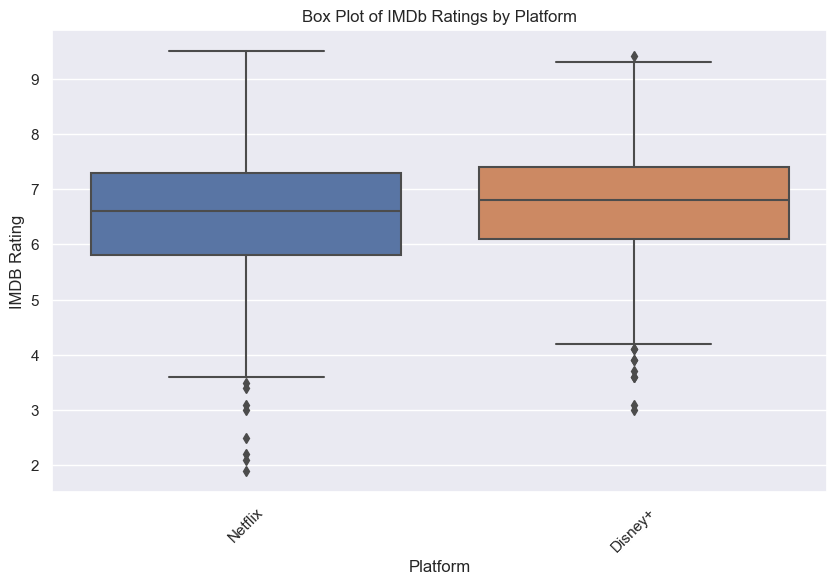

In [96]:
# Generate a box plot that shows the distrubution of IMDB rating for each platform.
plt.figure(figsize=(10, 6))
sns.boxplot(data=new_combined_df, x='platform', y='imdb_rating')
plt.title('Box Plot of IMDb Ratings by Platform')
plt.xlabel('Platform')
plt.ylabel('IMDB Rating')
plt.xticks(rotation=45)
# Save the plot to the output folder
plt.savefig(os.path.join('../output', 'BoxPlot_of_IMDbRatings_Platform.png'))
plt.show()

In [ ]:
# # change production_cost dtype to float
# new_combined_df['production_cost'] = new_combined_df['production_cost'].astype(float)

In [9]:
# # Group by 'platform' and calculate the average production cost for each platform
# average_production_cost_per_platform = new_combined_df.groupby('platform')['production_cost'].mean()

# # Plot the bar chart
# average_production_cost_per_platform.plot(kind='bar', figsize=(10, 6), color='skyblue')

# # Set the title and labels
# plt.title('Average Production Cost per Platform')
# plt.xlabel('Platform')
# plt.ylabel('Average Production Cost')

# # Show the plot
# plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
# plt.tight_layout()  # Adjust layout to prevent clipping of labels
# plt.savefig(os.path.join('../output', 'Average_Production_Cost_per_Platform.png'))
# plt.show()

In [97]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM 

mean= new_combined_df['imdb_rating'].groupby(new_combined_df['platform']).mean()
median= new_combined_df['imdb_rating'].groupby(new_combined_df['platform']).median()
var= new_combined_df['imdb_rating'].groupby(new_combined_df['platform']).var()
std= new_combined_df['imdb_rating'].groupby(new_combined_df['platform']).std()
sem= new_combined_df['imdb_rating'].groupby(new_combined_df['platform']).sem()

imdb_rating_summary_df=pd.DataFrame({'Mean IMDB Rating': mean,
                         'Median IMDB Rating': median,
                         'IMDB Rating Variance':var,
                         'IMDB Rating Std. Dev.':std,
                         'IMDB Rating Std. Err.':sem})

imdb_rating_summary_df

,Mean IMDB Rating,Median IMDB Rating,IMDB Rating Variance,IMDB Rating Std. Dev.,IMDB Rating Std. Err.
platform,,,,,
Disney+,6.720833,6.8,1.125609,1.060947,0.049683
Netflix,6.510445,6.6,1.411557,1.188090,0.052252


In [98]:
# Remove commas from imdb_votes column
new_combined_df['imdb_votes']   = new_combined_df['imdb_votes'].str.replace(',', '')

# Convert dtype of imdb_votes to float
new_combined_df['imdb_votes']  = new_combined_df['imdb_votes'] .astype(float)


In [99]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM 

mean= new_combined_df['imdb_votes'].groupby(new_combined_df['platform']).mean()
median= new_combined_df['imdb_votes'].groupby(new_combined_df['platform']).median()
var= new_combined_df['imdb_votes'].groupby(new_combined_df['platform']).var()
std= new_combined_df['imdb_votes'].groupby(new_combined_df['platform']).std()
sem= new_combined_df['imdb_votes'].groupby(new_combined_df['platform']).sem()

imdb_votes_summary_df=pd.DataFrame({'Mean IMDB Votes': mean,
                         'Median IMDB Votes': median,
                         'IMDB Votes Variance':var,
                         'IMDB Votes Std. Dev.':std,
                         'IMDB Votes Std. Err.':sem})

imdb_votes_summary_df

,Mean IMDB Votes,Median IMDB Votes,IMDB Votes Variance,IMDB Votes Std. Dev.,IMDB Votes Std. Err.
platform,,,,,
Disney+,61690.427632,2430.0,1.876574e+10,136988.086225,6415.054896
Netflix,61179.787234,6159.0,3.085073e+10,175643.753130,7724.803430


# Correlation and Regression for Netflix

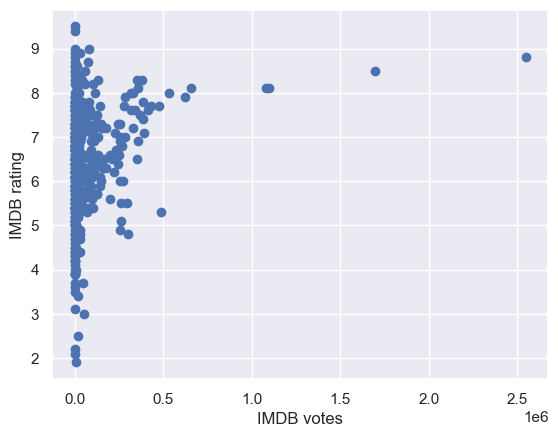

In [102]:
# Generate a scatter plot of IMDB Votes vs. the average rating for Netflix
netflix_data= new_combined_df.loc[new_combined_df['platform']=='Netflix'].groupby('imdb_id')
netflix_avg_imdb_rating = netflix_data['imdb_rating'].mean()
netflix_imdb_vote = netflix_data["imdb_votes"].unique()
plt.scatter(netflix_imdb_vote, netflix_avg_imdb_rating)
plt.xlabel("IMDB votes")
plt.ylabel("IMDB rating")
plt.show()

The correlation between IMDB votes and the average IMDB rating is 0.2089.


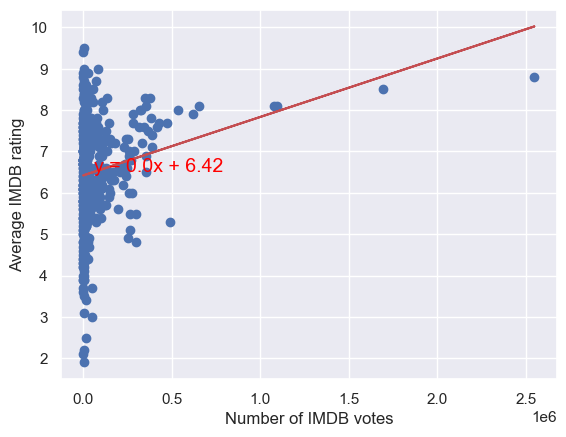

In [103]:
# Calculate the correlation coefficient and a linear regression model for IMDB Votes vs. the average rating for Netflix
correlation = st.pearsonr(netflix_imdb_vote, netflix_avg_imdb_rating)
rounded_corr = round(float(correlation[0]), 4)
netflix_imdb_vote = netflix_imdb_vote.astype(float)
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(netflix_imdb_vote, netflix_avg_imdb_rating)
line_eq = f'y = {(round(slope,5))}x + {(round(intercept,2))}'
regress_values = netflix_imdb_vote * slope + intercept
plt.scatter(netflix_imdb_vote, netflix_avg_imdb_rating)
plt.plot(netflix_imdb_vote,regress_values,"r-")
x_mean = np.mean(netflix_imdb_vote)
y_mean = np.mean(netflix_avg_imdb_rating)
x_text = x_mean
y_text = slope * x_mean + intercept
plt.annotate( line_eq,(x_text,y_text), fontsize=14, color='red')
plt.xlabel("Number of IMDB votes")
plt.ylabel("Average IMDB rating")
print(f"The correlation between IMDB votes and the average IMDB rating is {rounded_corr}.")
plt.show()

In [104]:
new_combined_df

,title,type,release_year,primary_genre,platform,date_added,imdb_id,imdb_rating,imdb_votes
0,Dick Johnson Is Dead,Movie,2020,Documentaries,Netflix,2021-09-25,tt11394180,7.4,7204.0
1,My Little Pony: A New Generation,Movie,2021,Children & Family Movies,Netflix,2021-09-24,tt10101702,6.8,4475.0
3,The Starling,Movie,2021,Comedies,Netflix,2021-09-24,tt5164438,6.4,15290.0
4,The Great British Baking Show,TV Show,2021,British TV Shows,Netflix,2021-09-24,tt1877368,8.6,12807.0
5,Sankofa,Movie,1993,Dramas,Netflix,2021-09-24,tt0108041,7.0,784.0
...,...,...,...,...,...,...,...,...,...
1194,Don's Fountain of Youth,Movie,1953,Animation,Disney+,2020-04-03,tt0045696,7.0,926.0
1195,Dolphin Reef,Movie,2018,Animals & Nature,Disney+,2020-04-03,tt10055028,7.4,1248.0
1196,Diving with Dolphins,Movie,2020,Animals & Nature,Disney+,2020-04-03,tt12100080,7.0,215.0
1198,A Tale of Two Critters,Movie,1977,Animals & Nature,Disney+,2020-04-03,tt0287003,5.9,244.0


# Correlation and Regression for Disney+ 

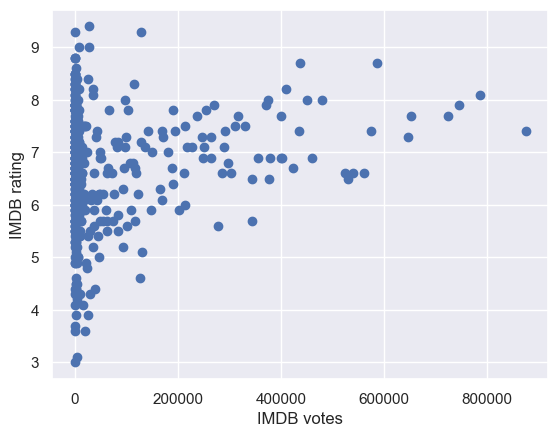

In [105]:
# Generate a scatter plot of IMDB votes vs. the average rating for Disney+
disney_data= new_combined_df.loc[new_combined_df['platform']=='Disney+'].groupby('imdb_id')
disney_avg_imdb_rating = disney_data['imdb_rating'].mean()
disney_imdb_vote = disney_data["imdb_votes"].unique()
plt.scatter(disney_imdb_vote, disney_avg_imdb_rating)
plt.xlabel("IMDB votes")
plt.ylabel("IMDB rating")
plt.show()

The correlation between IMDB votes and the average IMDB rating is 0.1647.


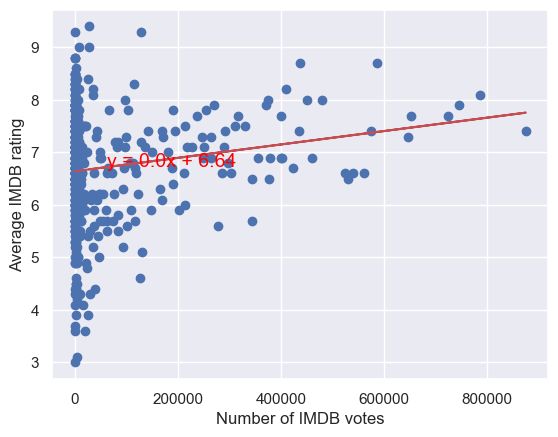

In [106]:
# Calculate the correlation coefficient and a linear regression model for IMDB Votes vs. the average rating for Disney+
correlation = st.pearsonr(disney_imdb_vote, disney_avg_imdb_rating)
rounded_corr = round(float(correlation[0]), 4)
disney_imdb_vote = disney_imdb_vote.astype(float)
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(disney_imdb_vote, disney_avg_imdb_rating)
line_eq = f'y = {(round(slope,5))}x + {(round(intercept,2))}'
regress_values = disney_imdb_vote * slope + intercept
plt.scatter(disney_imdb_vote, disney_avg_imdb_rating)
plt.plot(disney_imdb_vote,regress_values,"r-")
x_mean = np.mean(disney_imdb_vote)
y_mean = np.mean(disney_avg_imdb_rating)
x_text = x_mean
y_text = slope * x_mean + intercept
plt.annotate( line_eq,(x_text,y_text), fontsize=14, color='red')
plt.xlabel("Number of IMDB votes")
plt.ylabel("Average IMDB rating")
print(f"The correlation between IMDB votes and the average IMDB rating is {rounded_corr}.")
plt.show()